# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [1]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
summary = pd.DataFrame(columns=['test_accuracy', 'test_roc_auc', 'test_f1', 'test_average_precision'])
summary.index.name = 'method_name'

## Get the data

In [3]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

In [4]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [5]:
# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_artefact)

,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [6]:
# choose label
label = 'is_artefact'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
numerical_features = [f for f in features if not f in categorical_features]
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

# get reduced dataset
impact = pd.concat([impact[impact.is_artefact],
                    impact[~impact.is_artefact].iloc[0:20000]], ignore_index=True)

# shuffle data
rng = np.random.RandomState(42)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]
impact.reset_index(drop=True, inplace=True)

# get features matrix X (n_samples x n_features) and target array y (n_samples)
X = impact.drop(label, axis=1)
X = X.astype(float)
y = impact[label]

print(X.shape)
print(y.shape)
get_table(y)

(27199, 45)
(27199,)


,count_,freq_
False,20000,73.5%
True,7199,26.5%


In [7]:
X.head()

,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,sample_coverage,frequency_in_normals,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_total_AF_AFR,VEP_gnomAD_total_AF_AMR,VEP_gnomAD_total_AF_ASJ,VEP_gnomAD_total_AF_EAS,VEP_gnomAD_total_AF_FIN,VEP_gnomAD_total_AF_NFE,VEP_gnomAD_total_AF_OTH,VEP_gnomAD_total_AF_max,VEP_gnomAD_total_AF,Kaviar_AF,VEP_Consequence_frameshift_variant,VEP_Consequence_inframe_deletion,VEP_Consequence_inframe_insertion,VEP_Consequence_missense_variant,VEP_Consequence_splice_acceptor_variant,VEP_Consequence_splice_donor_variant,VEP_Consequence_start_lost,VEP_Consequence_stop_gained,VEP_Consequence_stop_lost,VEP_VARIANT_CLASS_SNV,VEP_VARIANT_CLASS_deletion,VEP_VARIANT_CLASS_indel,VEP_VARIANT_CLASS_insertion,VEP_VARIANT_CLASS_substitution,VEP_IMPACT_HIGH,VEP_IMPACT_MODERATE,VEP_CLIN_SIG_benign,VEP_CLIN_SIG_pathogenic,VEP_CLIN_SIG_unknown,VEP_in_dbSNP_False,VEP_in_dbSNP_True,gene_type_oncogene,gene_type_oncogene_and_tsg,gene_type_tsg,gene_type_unknown
0,807.0,0.11276,91.0,312.0,0.0,0.0,824.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,584.0,0.05822,34.0,383.0,0.0,0.0,632.0,0.0,3.0,0.000012,0.0,0.00003,0.0,0.0,0.0,0.000018,0.0,0.000030,0.000014,0.000007,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,673.0,0.51263,345.0,485.0,0.0,0.0,672.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,964.0,0.30498,294.0,371.0,0.0,0.0,669.0,0.0,14959.0,0.000004,0.0,0.00000,0.0,0.0,0.0,0.000009,0.0,0.000009,0.000005,0.000013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,366.0,0.36885,135.0,190.0,0.0,0.0,451.0,0.0,78.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [8]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Dummy

### Uniform

Generates predictions uniformly at random, expected accuracy: 0.5 | expected AUC: 0.5.

In [9]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='uniform', random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (0.60s)
▴ Mean accuracy    : 0.499 ± 0.012
▴ Mean ROC AUC     : 0.500 ± 0.000
▴ Mean F1-score    : 0.343 ± 0.016
▴ Average precision: 0.265 ± 0.000


In [10]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [0.06s | 0.01s]
  → accuracy     : [0.494 | 0.503]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.337 | 0.350]
  → avg precision: [0.265 | 0.265]
Fold 2: [0.05s | 0.00s]
  → accuracy     : [0.502 | 0.501]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.348 | 0.348]
  → avg precision: [0.265 | 0.265]
Fold 3: [0.05s | 0.00s]
  → accuracy     : [0.508 | 0.498]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.355 | 0.344]
  → avg precision: [0.265 | 0.265]
Fold 4: [0.05s | 0.01s]
  → accuracy     : [0.495 | 0.499]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.339 | 0.346]
  → avg precision: [0.265 | 0.265]
Fold 5: [0.05s | 0.00s]
  → accuracy     : [0.494 | 0.500]
  → 

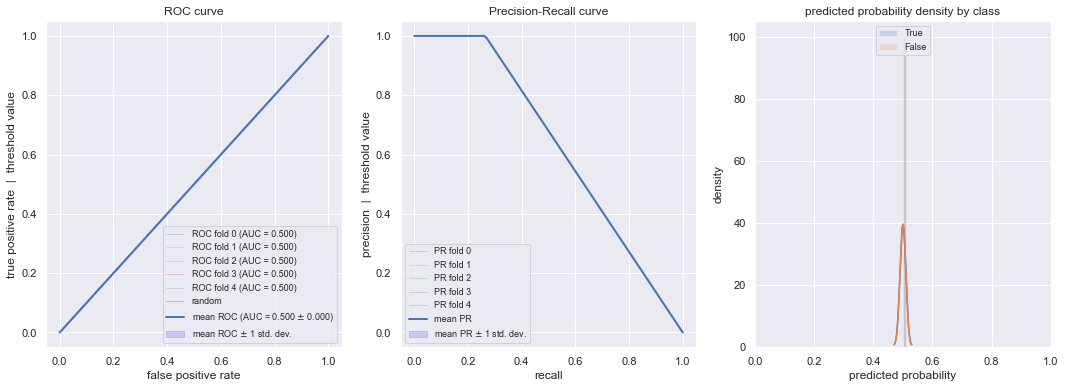

In [11]:
plot_threshold_decision_metrics(metrics, figsize=(18, 6), plot_thresholds=False)

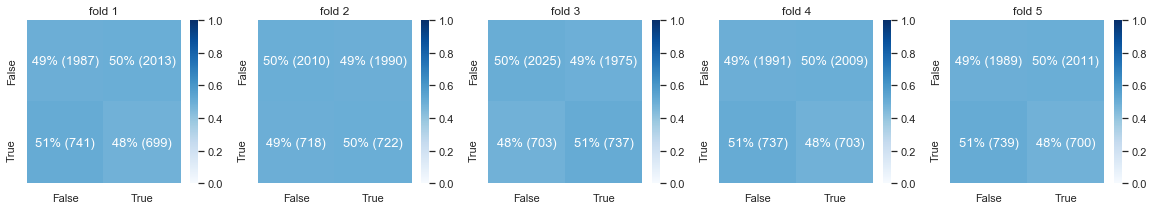

In [12]:
plot_confusion_matrix(metrics)

Run learning curves computation... done! (1.88s)


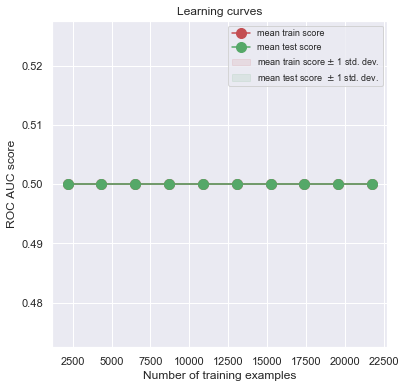

In [13]:
plot_learning_curves(model, X, y, cv_strategy, figsize=(6, 6))

In [14]:
summary.loc['Uniform'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

### Most Frequent

Always predicts the most frequent label in the training set → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [15]:
model = DummyClassifier(strategy='most_frequent', random_state=42)

metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model...

/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-pac

 done! (0.58s)
▴ Mean accuracy    : 0.735 ± 0.000
▴ Mean ROC AUC     : 0.500 ± 0.000
▴ Mean F1-score    : 0.000 ± 0.000
▴ Average precision: 0.265 ± 0.000


In [16]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [0.05s | 0.01s]
  → accuracy     : [0.735 | 0.735]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.000 | 0.000]
  → avg precision: [0.265 | 0.265]
Fold 2: [0.05s | 0.00s]
  → accuracy     : [0.735 | 0.735]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.000 | 0.000]
  → avg precision: [0.265 | 0.265]
Fold 3: [0.04s | 0.00s]
  → accuracy     : [0.735 | 0.735]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.000 | 0.000]
  → avg precision: [0.265 | 0.265]
Fold 4: [0.04s | 0.00s]
  → accuracy     : [0.735 | 0.735]
  → ROC AUC      : [0.500 | 0.500]
  → F1-score     : [0.000 | 0.000]
  → avg precision: [0.265 | 0.265]
Fold 5: [0.04s | 0.00s]
  → accuracy     : [0.735 | 0.735]
  → 

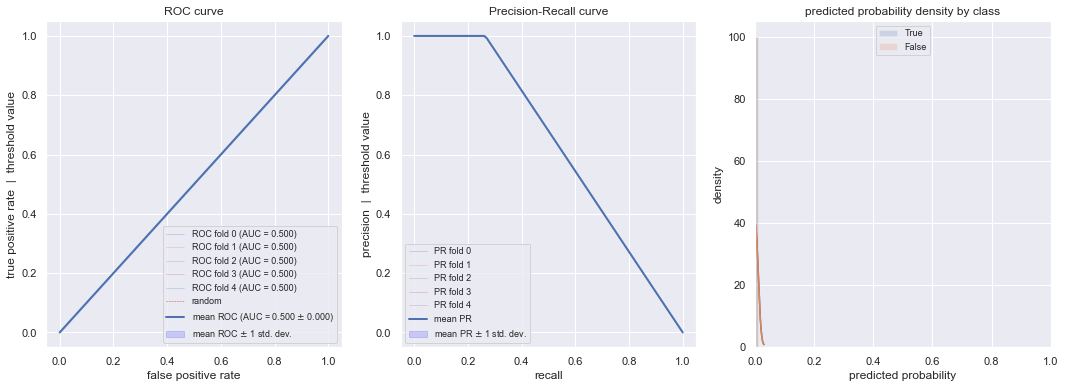

In [17]:
plot_threshold_decision_metrics(metrics, figsize=(18, 6), plot_thresholds=False)

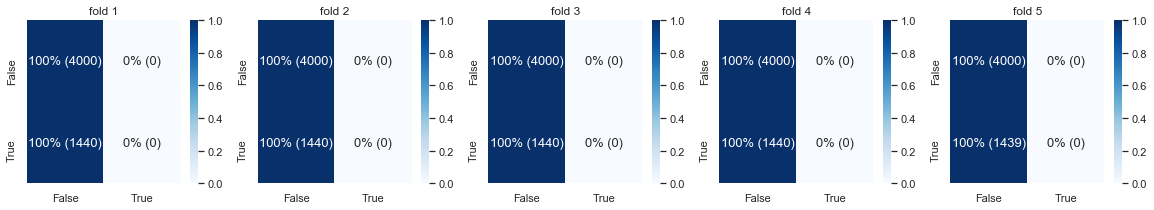

In [18]:
plot_confusion_matrix(metrics)

Run learning curves computation... done! (1.91s)


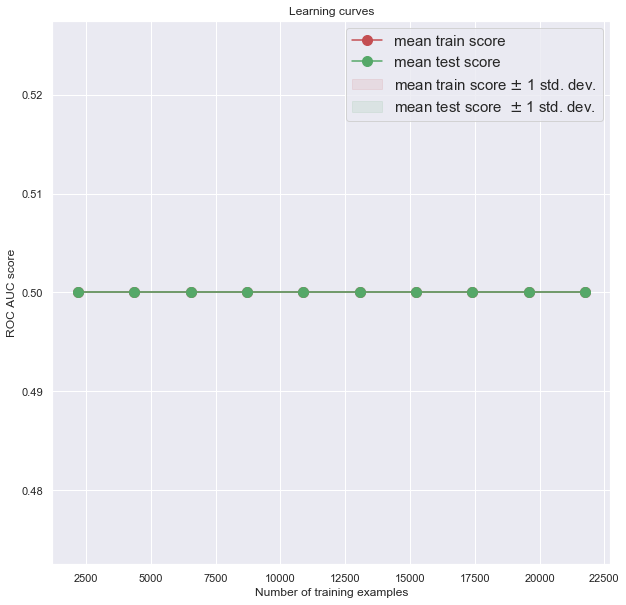

In [19]:
plot_learning_curves(model, X, y, cv_strategy)

In [20]:
summary.loc['MostFrequent'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Gaussian Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', GaussianNB())])
metrics = run_model(model, X, y, cv_strategy)
print_mean_metrics(metrics)

Run model... done! (1.70s)
▴ Mean accuracy    : 0.850 ± 0.008
▴ Mean ROC AUC     : 0.857 ± 0.007
▴ Mean F1-score    : 0.625 ± 0.028
▴ Average precision: 0.759 ± 0.013


In [22]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [0.10s | 0.03s]
  → accuracy     : [0.847 | 0.845]
  → ROC AUC      : [0.860 | 0.855]
  → F1-score     : [0.618 | 0.609]
  → avg precision: [0.759 | 0.751]
Fold 2: [0.10s | 0.03s]
  → accuracy     : [0.853 | 0.853]
  → ROC AUC      : [0.858 | 0.859]
  → F1-score     : [0.631 | 0.632]
  → avg precision: [0.764 | 0.765]
Fold 3: [0.11s | 0.03s]
  → accuracy     : [0.851 | 0.848]
  → ROC AUC      : [0.860 | 0.858]
  → F1-score     : [0.622 | 0.613]
  → avg precision: [0.767 | 0.759]
Fold 4: [0.10s | 0.03s]
  → accuracy     : [0.855 | 0.858]
  → ROC AUC      : [0.852 | 0.864]
  → F1-score     : [0.645 | 0.649]
  → avg precision: [0.750 | 0.773]
Fold 5: [0.10s | 0.03s]
  → accuracy     : [0.846 | 0.849]
  → 

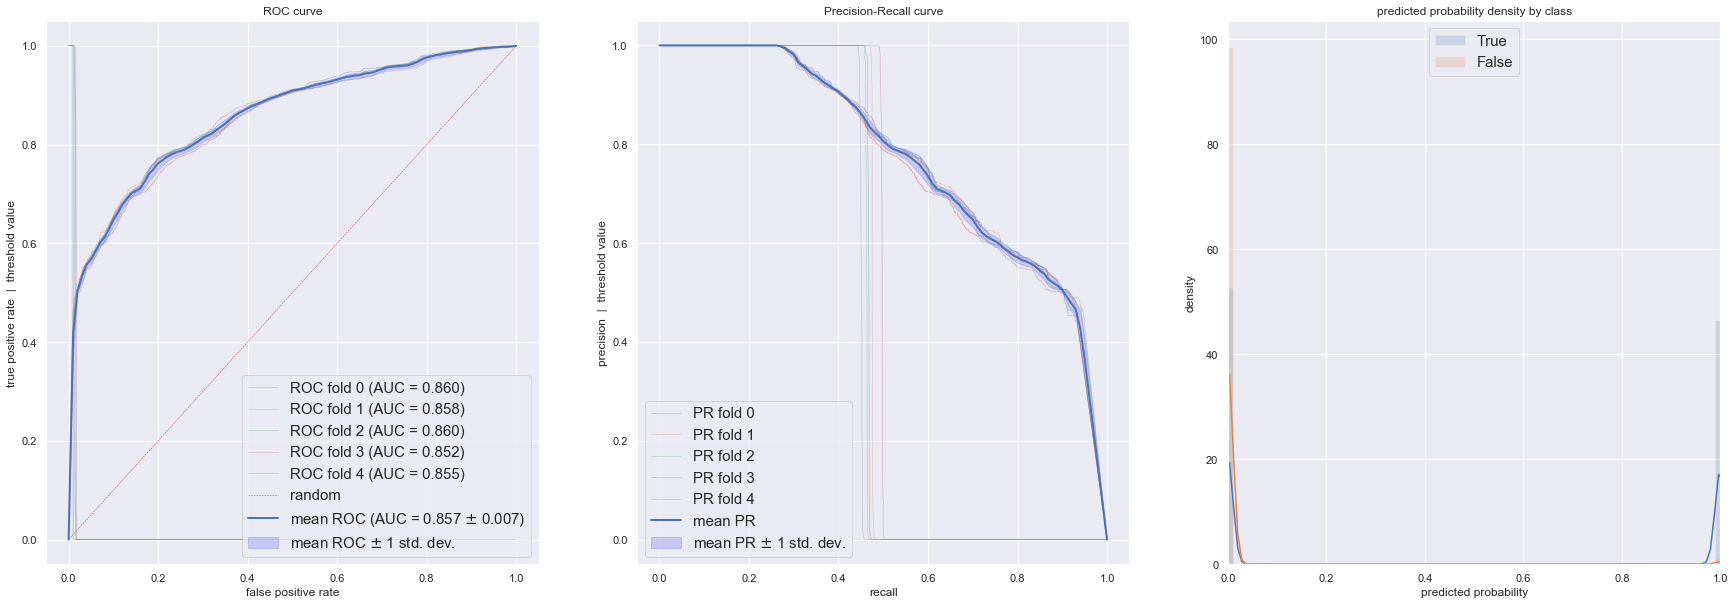

In [23]:
plot_threshold_decision_metrics(metrics)

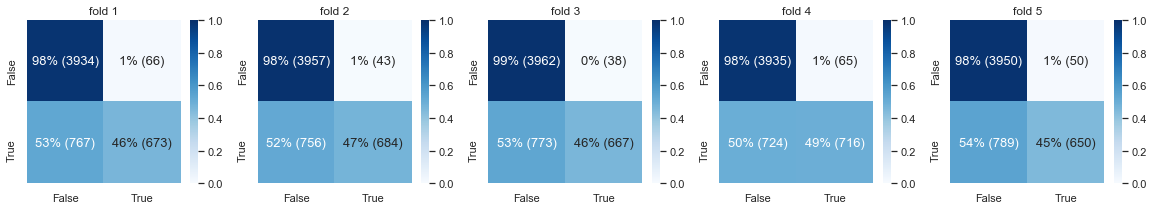

In [24]:
plot_confusion_matrix(metrics)

Run learning curves computation... done! (3.87s)


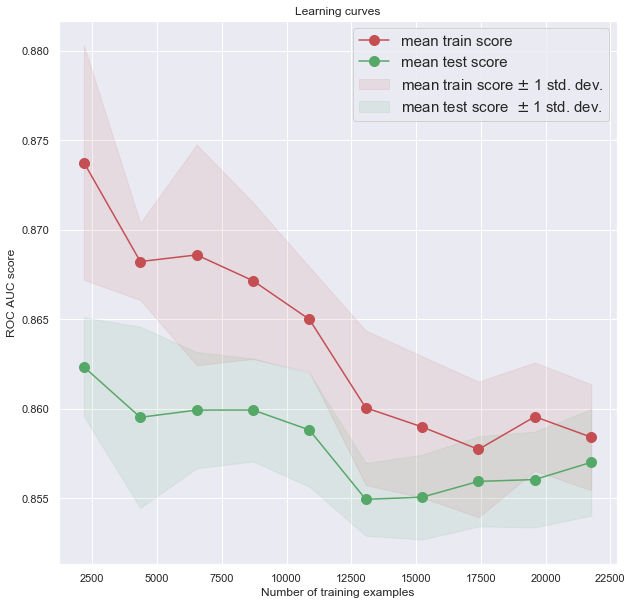

In [25]:
plot_learning_curves(model, X, y, cv_strategy, n_jobs=-1)

In [26]:
summary.loc['GausssianNaiveBayes'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

## Logistic Regression

### Ridge regression (L2 regularization)

#### Run the model

This model performs an automatic grid search over its parameters.

In [27]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])
metrics = run_model(model, X, y, cv_strategy, n_jobs=-1)
print_mean_metrics(metrics)

Run model... done! (5.88s)
▴ Mean accuracy    : 0.879 ± 0.004
▴ Mean ROC AUC     : 0.898 ± 0.009
▴ Mean F1-score    : 0.728 ± 0.012
▴ Average precision: 0.843 ± 0.016


In [28]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [5.20s | 0.03s]
  → accuracy     : [0.883 | 0.879]
  → ROC AUC      : [0.904 | 0.898]
  → F1-score     : [0.739 | 0.729]
  → avg precision: [0.854 | 0.844]
Fold 2: [5.16s | 0.03s]
  → accuracy     : [0.878 | 0.880]
  → ROC AUC      : [0.894 | 0.900]
  → F1-score     : [0.722 | 0.731]
  → avg precision: [0.837 | 0.848]
Fold 3: [5.18s | 0.03s]
  → accuracy     : [0.880 | 0.880]
  → ROC AUC      : [0.898 | 0.899]
  → F1-score     : [0.726 | 0.729]
  → avg precision: [0.843 | 0.845]
Fold 4: [5.14s | 0.03s]
  → accuracy     : [0.877 | 0.882]
  → ROC AUC      : [0.893 | 0.901]
  → F1-score     : [0.725 | 0.734]
  → avg precision: [0.834 | 0.849]
Fold 5: [5.26s | 0.03s]
  → accuracy     : [0.879 | 0.880]
  → 

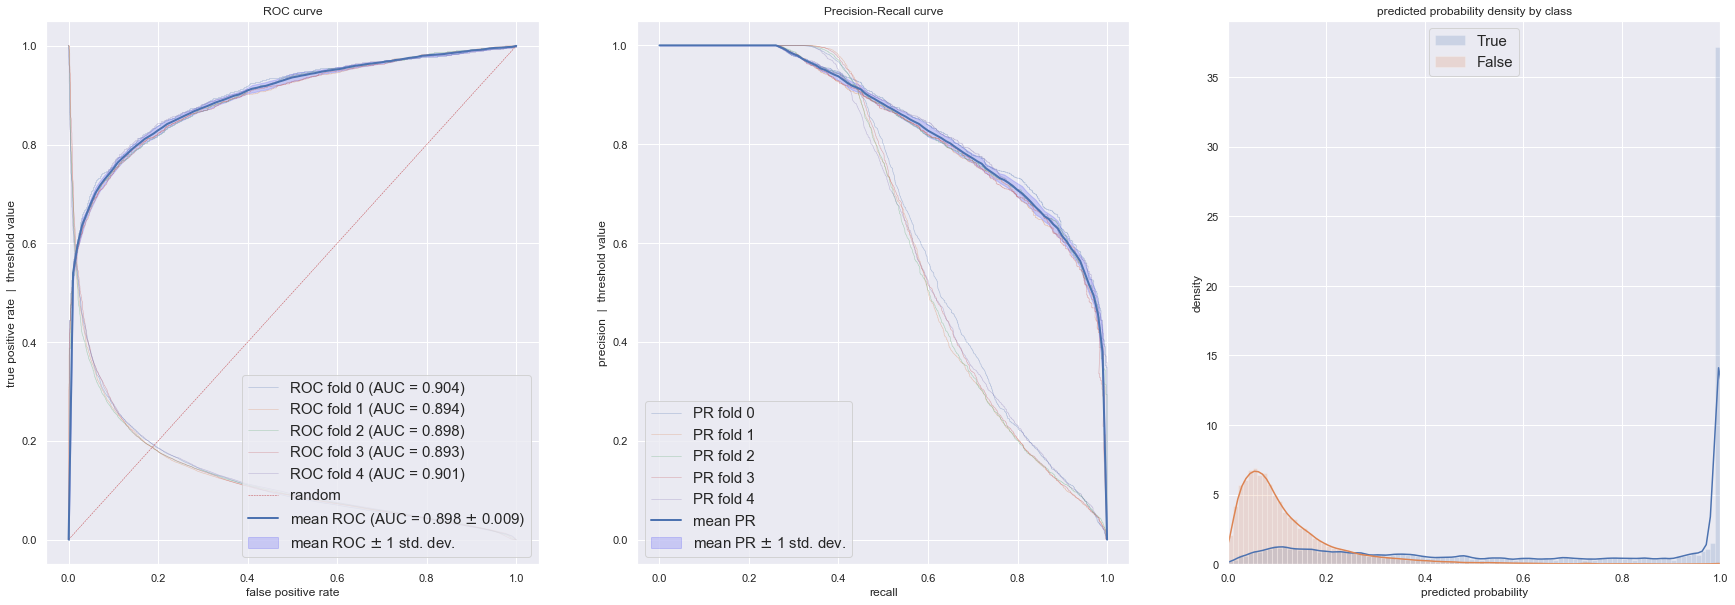

In [29]:
plot_threshold_decision_metrics(metrics)

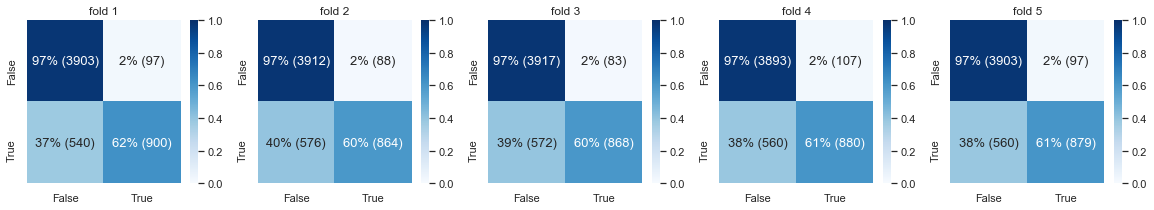

In [30]:
plot_confusion_matrix(metrics)

Run learning curves computation... done! (31.80s)


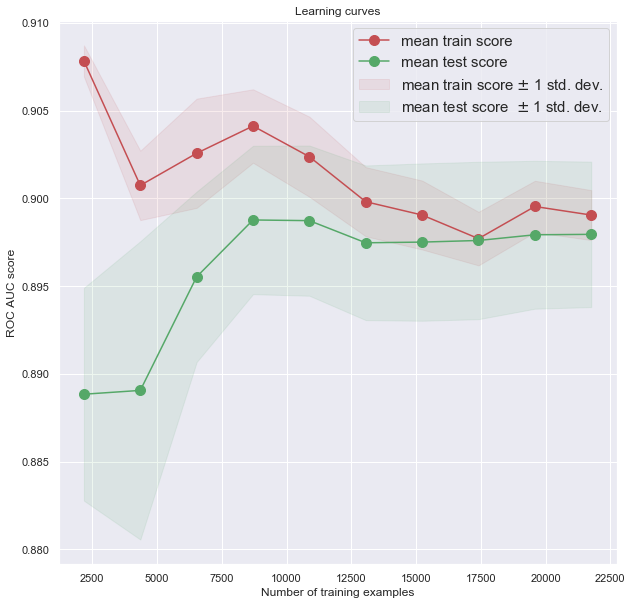

In [31]:
plot_learning_curves(model, X, y, cv_strategy, n_jobs=-1)

In [32]:
summary.loc['RidgeRegression'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

#### Study coefficients

In [33]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', max_iter=2000, n_jobs=-1, random_state=42))])
model.fit(X, y);

"If your variables are positively correlated, then the coefficients will be negatively correlated, which can lead to a wrong sign on one of the coefficients.", see https://stats.stackexchange.com/questions/1580/regression-coefficients-that-flip-sign-after-including-other-predictors.

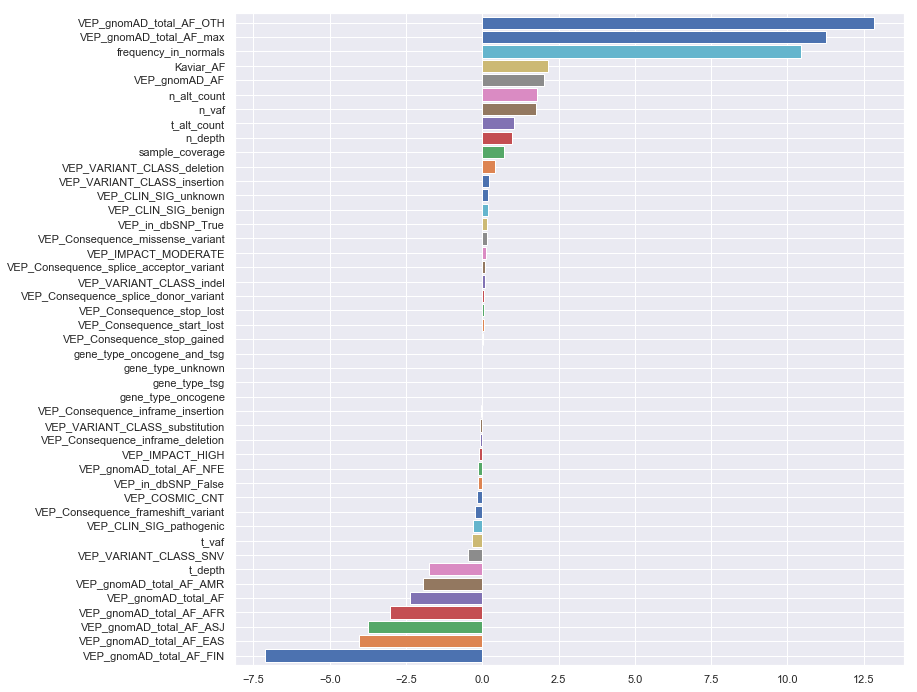

In [34]:
feature_coefficient = pd.DataFrame({'coeff': model.named_steps['classify'].coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 12))
feature_coefficient.coeff.plot.barh(width=0.85);

### Lasso regression (L1 regularization)

#### Run the model

Scaling gives worst result, and run for way longer for some reason:

In [35]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', random_state=42))])
metrics = run_model(model, X, y, cv_strategy, n_jobs=-1)
print_mean_metrics(metrics)

Run model... done! (109.08s)
▴ Mean accuracy    : 0.879 ± 0.004
▴ Mean ROC AUC     : 0.898 ± 0.009
▴ Mean F1-score    : 0.728 ± 0.012
▴ Average precision: 0.843 ± 0.016


In [36]:
metrics_unscaled = run_model(LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', random_state=42), X, y, cv_strategy, n_jobs=-1)
print_mean_metrics(metrics_unscaled)

Run model... done! (10.71s)
▴ Mean accuracy    : 0.880 ± 0.004
▴ Mean ROC AUC     : 0.898 ± 0.009
▴ Mean F1-score    : 0.729 ± 0.012
▴ Average precision: 0.844 ± 0.015


In [37]:
metrics = metrics_unscaled

In [38]:
print_fold_metrics(metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]

Fold 1: [9.74s | 0.02s]
  → accuracy     : [0.883 | 0.880]
  → ROC AUC      : [0.904 | 0.897]
  → F1-score     : [0.739 | 0.729]
  → avg precision: [0.853 | 0.843]
Fold 2: [9.08s | 0.03s]
  → accuracy     : [0.878 | 0.880]
  → ROC AUC      : [0.894 | 0.900]
  → F1-score     : [0.723 | 0.731]
  → avg precision: [0.838 | 0.848]
Fold 3: [9.86s | 0.02s]
  → accuracy     : [0.881 | 0.880]
  → ROC AUC      : [0.898 | 0.899]
  → F1-score     : [0.728 | 0.729]
  → avg precision: [0.843 | 0.845]
Fold 4: [8.22s | 0.03s]
  → accuracy     : [0.878 | 0.882]
  → ROC AUC      : [0.894 | 0.901]
  → F1-score     : [0.727 | 0.734]
  → avg precision: [0.835 | 0.849]
Fold 5: [8.93s | 0.02s]
  → accuracy     : [0.879 | 0.880]
  → 

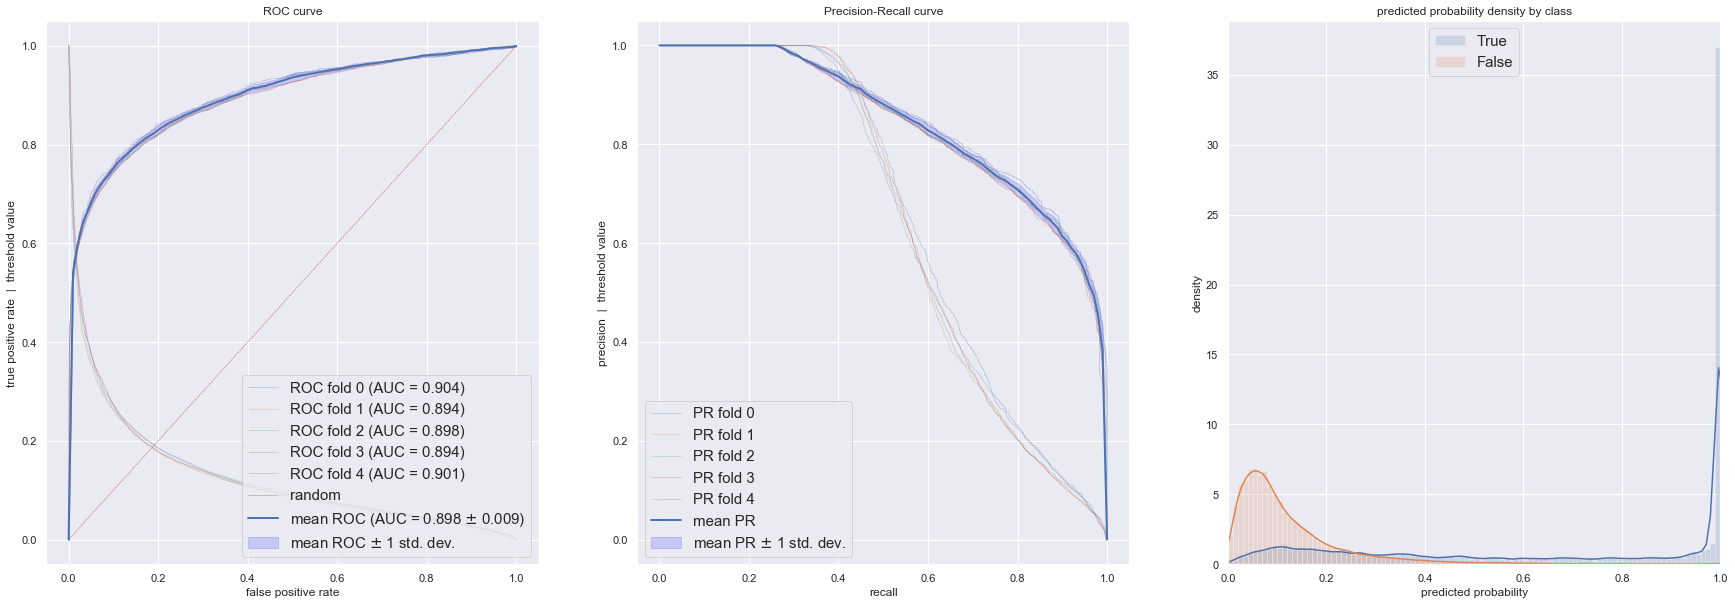

In [39]:
plot_threshold_decision_metrics(metrics)

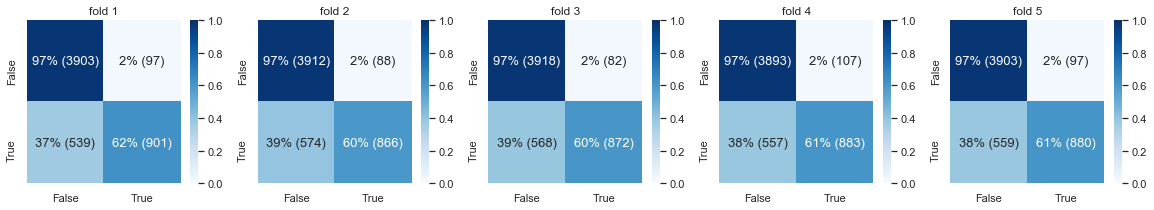

In [40]:
plot_confusion_matrix(metrics)

Run learning curves computation... done! (313.85s)


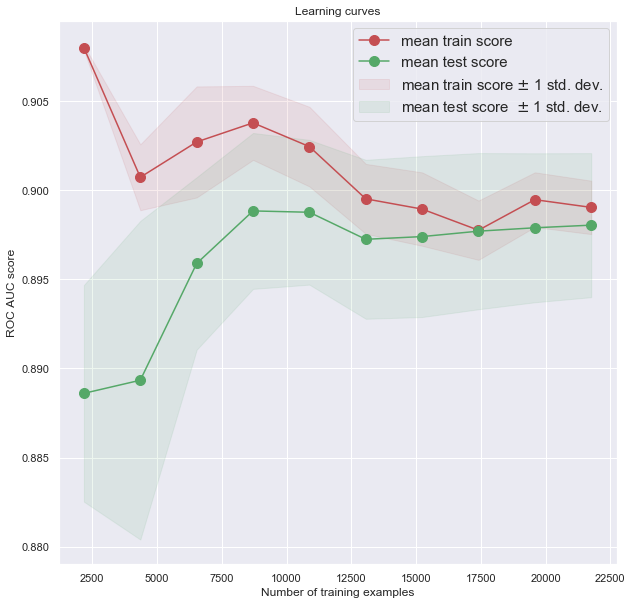

In [41]:
# with the unscaled version
plot_learning_curves(LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', random_state=42), X, y, cv_strategy, n_jobs=-1)

In [42]:
summary.loc['LassoRegression'] = [metrics.test_accuracy.mean(), metrics.test_roc_auc.mean(), metrics.test_f1.mean(), metrics.test_average_precision.mean()]

#### Study coefficients

We change the regularization to make it stronger (otherwise we get the same result as for the ridge regression previously):

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=42))])
model.fit(X, y);

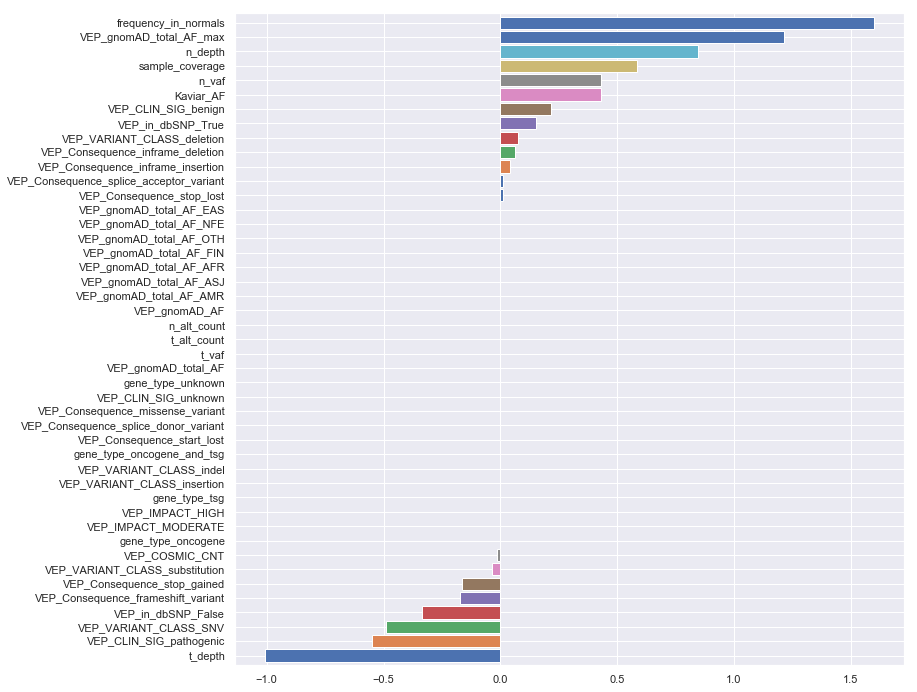

In [44]:
feature_coefficient = pd.DataFrame({'coeff': model.named_steps['classify'].coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 12))
feature_coefficient.coeff.plot.barh(width=0.85);

In [45]:
feature_coefficient.index[feature_coefficient.coeff == 0].tolist()

['gene_type_oncogene',
 'VEP_IMPACT_MODERATE',
 'VEP_IMPACT_HIGH',
 'gene_type_tsg',
 'VEP_VARIANT_CLASS_insertion',
 'VEP_VARIANT_CLASS_indel',
 'gene_type_oncogene_and_tsg',
 'VEP_Consequence_start_lost',
 'VEP_Consequence_splice_donor_variant',
 'VEP_Consequence_missense_variant',
 'VEP_CLIN_SIG_unknown',
 'gene_type_unknown',
 'VEP_gnomAD_total_AF',
 't_vaf',
 't_alt_count',
 'n_alt_count',
 'VEP_gnomAD_AF',
 'VEP_gnomAD_total_AF_AMR',
 'VEP_gnomAD_total_AF_ASJ',
 'VEP_gnomAD_total_AF_AFR',
 'VEP_gnomAD_total_AF_FIN',
 'VEP_gnomAD_total_AF_OTH',
 'VEP_gnomAD_total_AF_NFE',
 'VEP_gnomAD_total_AF_EAS']

In [46]:
summary.style.highlight_max(axis=0, color='yellow').set_precision(3)

,test_accuracy,test_roc_auc,test_f1,test_average_precision
method_name,,,,
Uniform,0.499,0.5,0.343,0.265
MostFrequent,0.735,0.5,0,0.265
GausssianNaiveBayes,0.85,0.857,0.625,0.759
RidgeRegression,0.879,0.898,0.728,0.843
LassoRegression,0.88,0.898,0.729,0.844


## K Nearest Neighbors

In [92]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < kNN >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [93]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < kNN >: </span>✅ job found and reloaded

In [74]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_kNN


<span style="color:green">Job < kNN >: </span>✅ data loaded

In [75]:
print(job.script_path)

../ssh_remote_jobs/job_kNN/script.ipy


In [78]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
parameters_grid = [
    {'classify__n_neighbors': [5, 10, 20, 25, 30, 40, 50, 60, 100], 'classify__weights': ['uniform', 'distance']}
]
pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', KNeighborsClassifier())])
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_kNN/script.ipy


In [79]:
job.run(n_jobs=5, short_job=False)

➞ scp ../ssh_remote_jobs/job_kNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100% 1080     2.6KB/s   00:00    
X.pkl                                         100% 5053KB   2.5MB/s   00:02    
y.pkl                                         100%   27KB  37.3KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_kNN
Job <28505498> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < kNN >: </span>✅ submitted<br>

In [98]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < kNN >: </span>✅ job found and reloaded

<span style="color:green">Job < kNN >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_kNN to ../ssh_remote_jobs/job_kNN
metrics.pkl                                   100%  601KB   3.9MB/s   00:00    
job_output.txt                                100%  310KB   2.3MB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.878 ± 0.005
▴ Mean ROC AUC     : 0.909 ± 0.008
▴ Mean F1-score    : 0.723 ± 0.013
▴ Average precision: 0.848 ± 0.009


In [99]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [2508.97s | 54.30s]
  → accuracy     : [0.875 | 1.000]
  → ROC AUC      : [0.911 | 1.000]
  → F1-score     : [0.716 | 1.000]
  → avg precision: [0.849 | 1.000]
  → best hyperparameters: {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
Fold 2: [2729.65s | 28.23s]
  → accuracy     : [0.879 | 1.000]
  → ROC AUC      : [0.903 | 1.000]
  → F1-score     : [0.727 | 1.000]
  → avg precision: [0.846 | 1.000]
  → best hyperparameters: {'classify__n_neighbors': 25, 'classify__weights': 'distance'}
Fold 3: [2157.13s | 104.07s]
  → accuracy     : [0.880 | 1.000]
  → ROC AUC      : [0.912 | 1.000]
  → F1-score     : [0.726 | 1.000

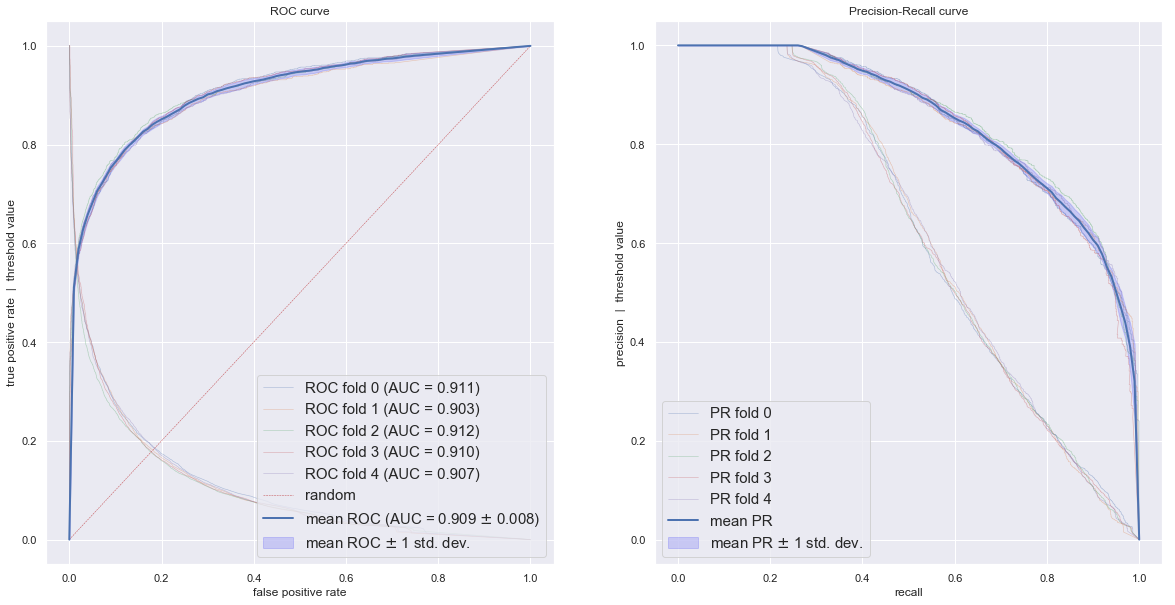

In [100]:
plot_roc_and_precision_recall(job.metrics)

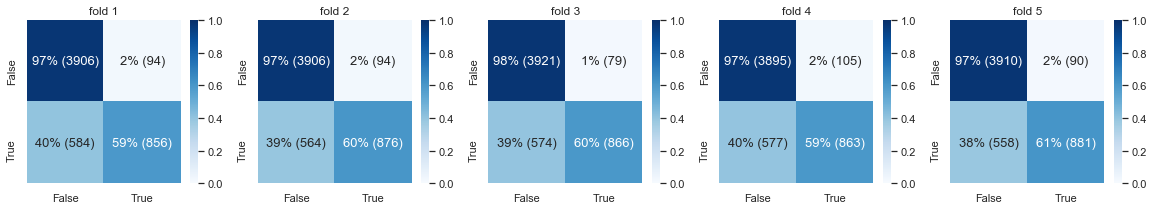

In [101]:
plot_confusion_matrix(job.metrics)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → classify__n_neighbors: [5 10 20 25 30 40 50 60 100]
  → classify__weights    : ['distance' 'uniform']
Best hyperparameters for each fold:
fold 0: {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
fold 1: {'classify__n_neighbors': 25, 'classify__weights': 'distance'}
fold 2: {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
fold 3: {'classify__n_neighbors': 30, 'classify__weights': 'distance'}
fold 4: {'classify__n_neighbors': 25, 'classify__weights': 'distance'}


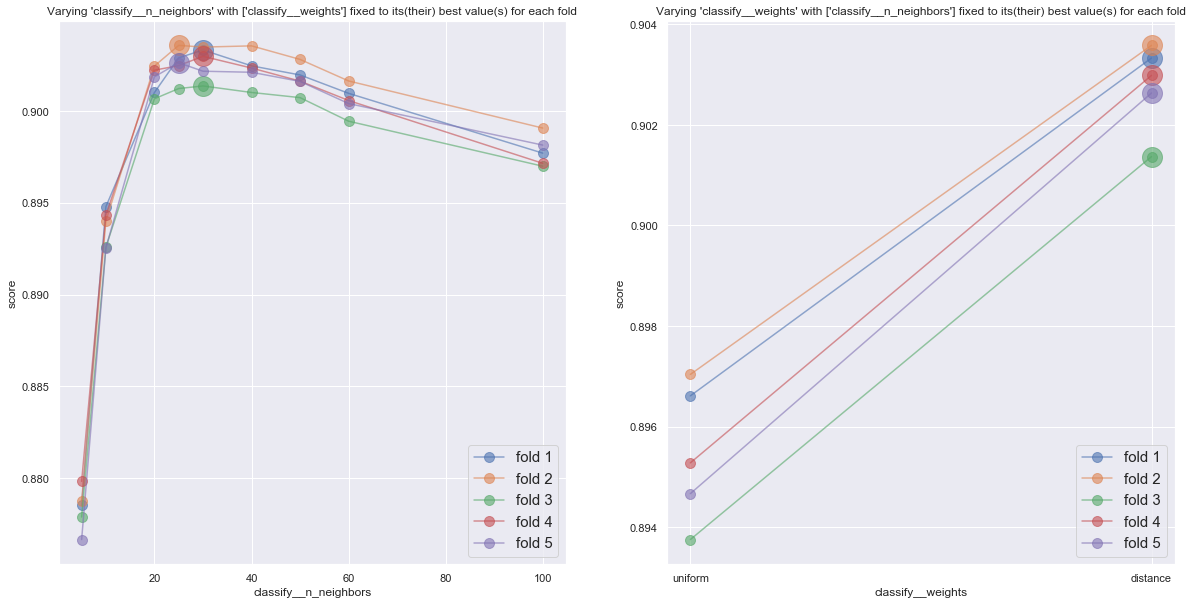

In [102]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [138]:
summary.loc['kNN'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

## Support Vector Machine

In [90]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < SVM >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [166]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < SVM >: </span>✅ job found and reloaded

In [167]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_SVM


<span style="color:green">Job < SVM >: </span>✅ data loaded

In [168]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
parameters_grid = [
    {'classify__C': [0.1, 0.8, 0.9, 1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'classify__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
]
pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', SVC(probability=True, cache_size=1000, gamma='scale'))])
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_SVM/script.ipy


In [169]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ../ssh_remote_jobs/job_SVM to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100%  281KB   1.1MB/s   00:00    
metrics.pkl                                   100%  766KB   9.9MB/s   00:00    
script.ipy                                    100% 1102     6.8KB/s   00:00    
X.pkl                                         100% 5053KB  16.0MB/s   00:00    
y.pkl                                         100%   27KB   2.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_SVM
Job <28482671> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < SVM >: </span>✅ submitted<br>

In [9]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < SVM >: </span>✅ job found and reloaded

<span style="color:green">Job < SVM >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_SVM to ../ssh_remote_jobs/job_SVM
metrics.pkl                                   100%  789KB   6.0MB/s   00:00    
job_output.txt                                100%  882KB   6.4MB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.880 ± 0.008
▴ Mean ROC AUC     : 0.910 ± 0.004
▴ Mean F1-score    : 0.725 ± 0.019
▴ Average precision: 0.858 ± 0.009


In [10]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [10753.98s | 43.75s]
  → accuracy     : [0.884 | 0.887]
  → ROC AUC      : [0.912 | 0.918]
  → F1-score     : [0.737 | 0.741]
  → avg precision: [0.863 | 0.872]
  → best hyperparameters: {'classify__C': 2, 'classify__kernel': 'rbf'}
Fold 2: [13999.91s | 11.03s]
  → accuracy     : [0.880 | 0.886]
  → ROC AUC      : [0.912 | 0.919]
  → F1-score     : [0.724 | 0.739]
  → avg precision: [0.859 | 0.871]
  → best hyperparameters: {'classify__C': 2, 'classify__kernel': 'rbf'}
Fold 3: [12798.51s | 11.56s]
  → accuracy     : [0.884 | 0.885]
  → ROC AUC      : [0.908 | 0.918]
  → F1-score     : [0.732 | 0.737]
  → avg precision: [0.858 | 0.

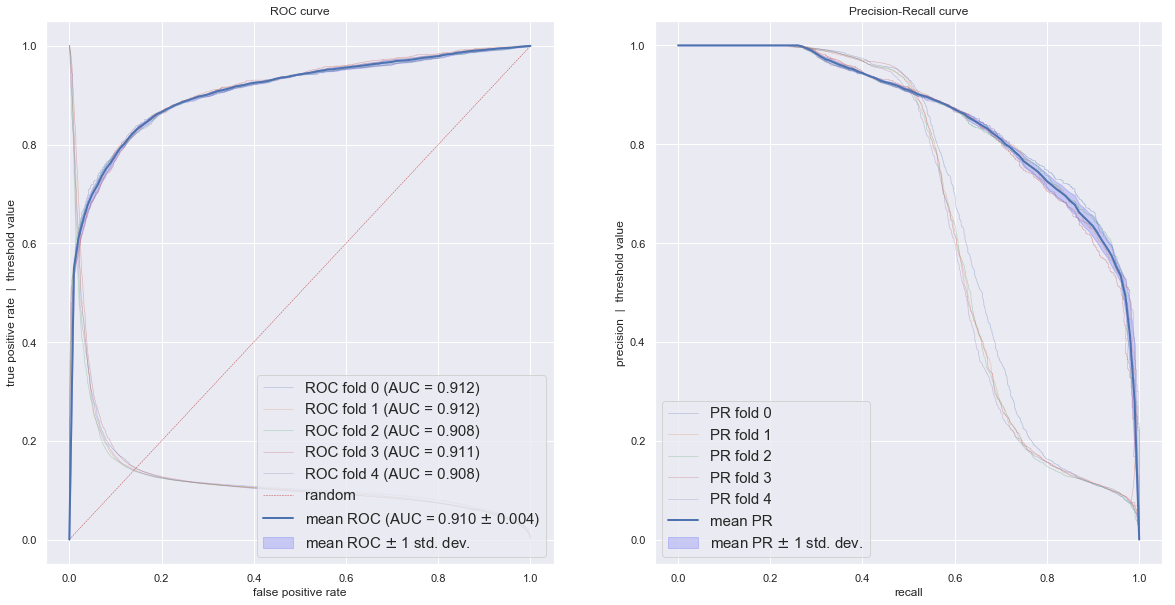

In [11]:
plot_roc_and_precision_recall(job.metrics)

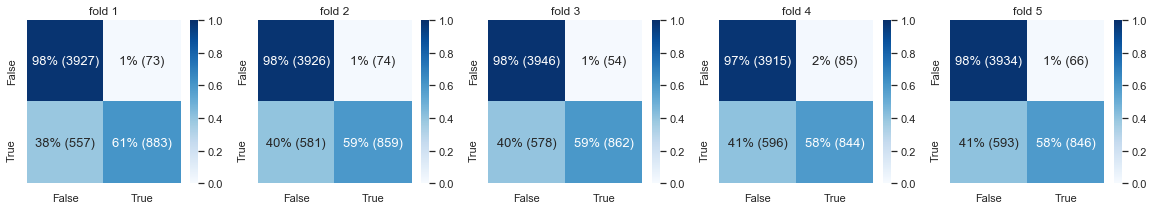

In [12]:
plot_confusion_matrix(job.metrics)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → classify__C     : [0.1 0.8 0.9 1.0 2 3 4 5 6 7 8 9 10]
  → classify__kernel: ['linear' 'poly' 'rbf' 'sigmoid']
Best hyperparameters for each fold:
fold 0: {'classify__C': 2, 'classify__kernel': 'rbf'}
fold 1: {'classify__C': 2, 'classify__kernel': 'rbf'}
fold 2: {'classify__C': 2, 'classify__kernel': 'rbf'}
fold 3: {'classify__C': 1.0, 'classify__kernel': 'rbf'}
fold 4: {'classify__C': 2, 'classify__kernel': 'rbf'}


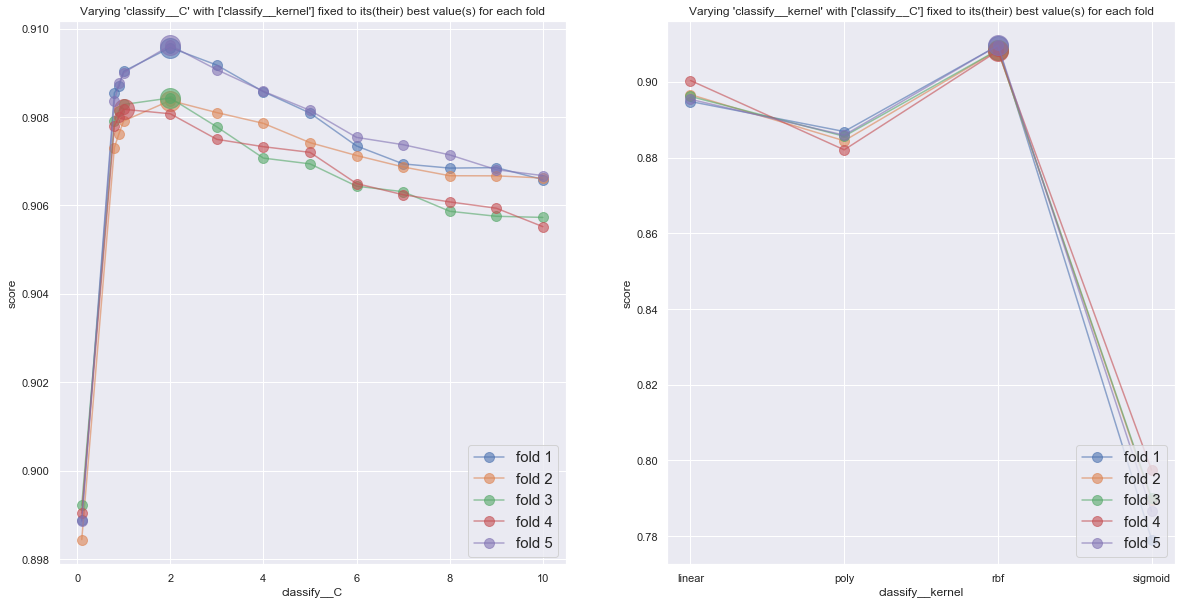

In [13]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [16]:
summary.loc['SVM'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

## Random Forest

### Create job

In [74]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < RandomForest >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [80]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < RandomForest >: </span>✅ job found and reloaded

In [76]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest


<span style="color:green">Job < RandomForest >: </span>✅ data loaded

In [77]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50, 100, 200]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=20)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_RandomForest/script.ipy


In [78]:
job.run(n_jobs=20, short_job=False, memory=32)

➞ scp ../ssh_remote_jobs/job_RandomForest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1515     1.5KB/s   00:01    
metrics.pkl                                   100%  692KB   7.8MB/s   00:00    
script.ipy                                    100%  934     0.9KB/s   00:01    
X.pkl                                         100% 5053KB  13.0MB/s   00:00    
y.pkl                                         100%   27KB  64.3KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest
Job <28479739> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest >: </span>✅ submitted<br>

In [96]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < RandomForest >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest to ../ssh_remote_jobs/job_RandomForest
metrics.pkl                                   100%  692KB   7.3MB/s   00:00    
job_output.txt                                100% 1515   384.1KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.904 ± 0.010
▴ Mean ROC AUC     : 0.938 ± 0.005
▴ Mean F1-score    : 0.798 ± 0.020
▴ Average precision: 0.897 ± 0.009


In [91]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [1493.43s | 9.13s]
  → accuracy     : [0.905 | 0.989]
  → ROC AUC      : [0.940 | 1.000]
  → F1-score     : [0.801 | 0.979]
  → avg precision: [0.899 | 1.000]
  → best hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
Fold 2: [1529.63s | 4.73s]
  → accuracy     : [0.906 | 0.991]
  → ROC AUC      : [0.937 | 1.000]
  → F1-score     : [0.800 | 0.982]
  → avg precision: [0.897 | 1.000]
  → best hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
Fold 3: [1499.32s | 10.03s]
  → accuracy     : [0.912 | 0.989]
  → ROC AUC      : [0.941 | 1.000]
  → F1-score     : [0.813 | 0.978]

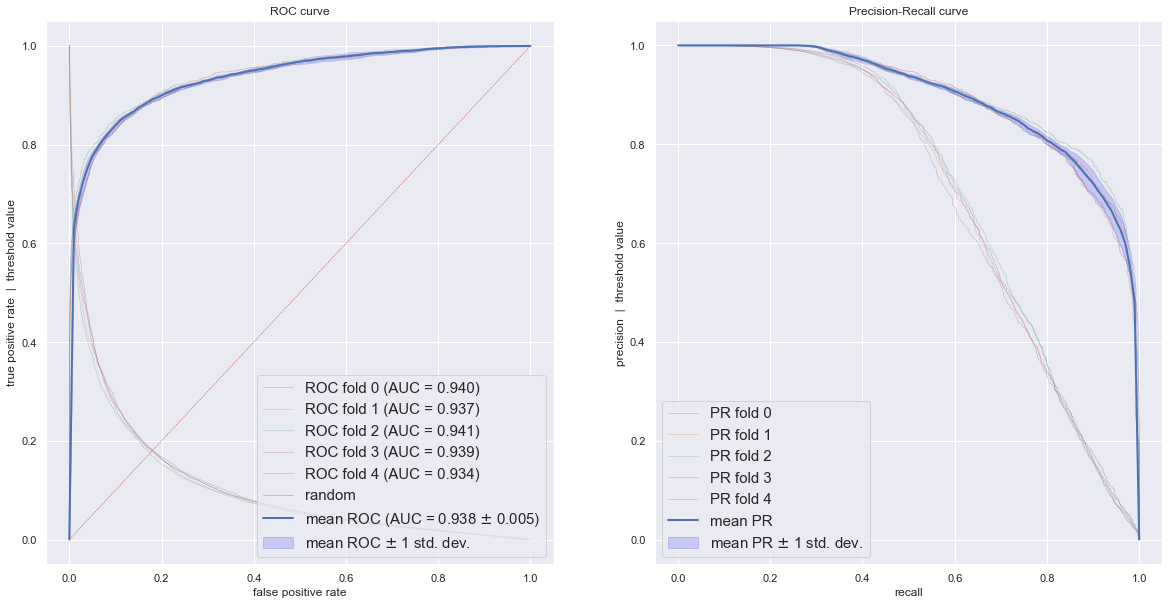

In [141]:
plot_roc_and_precision_recall(job.metrics)

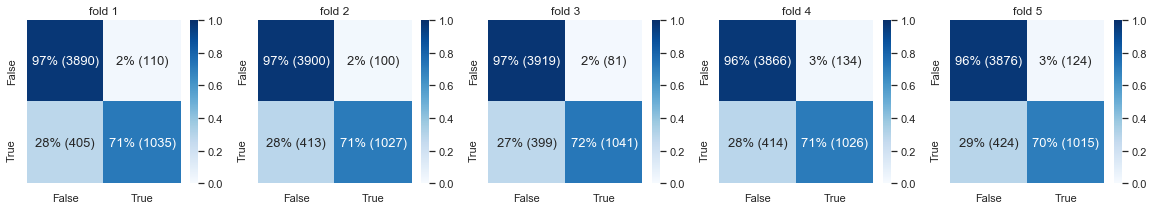

In [142]:
plot_confusion_matrix(job.metrics)

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50 100 200]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 3: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 4: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}


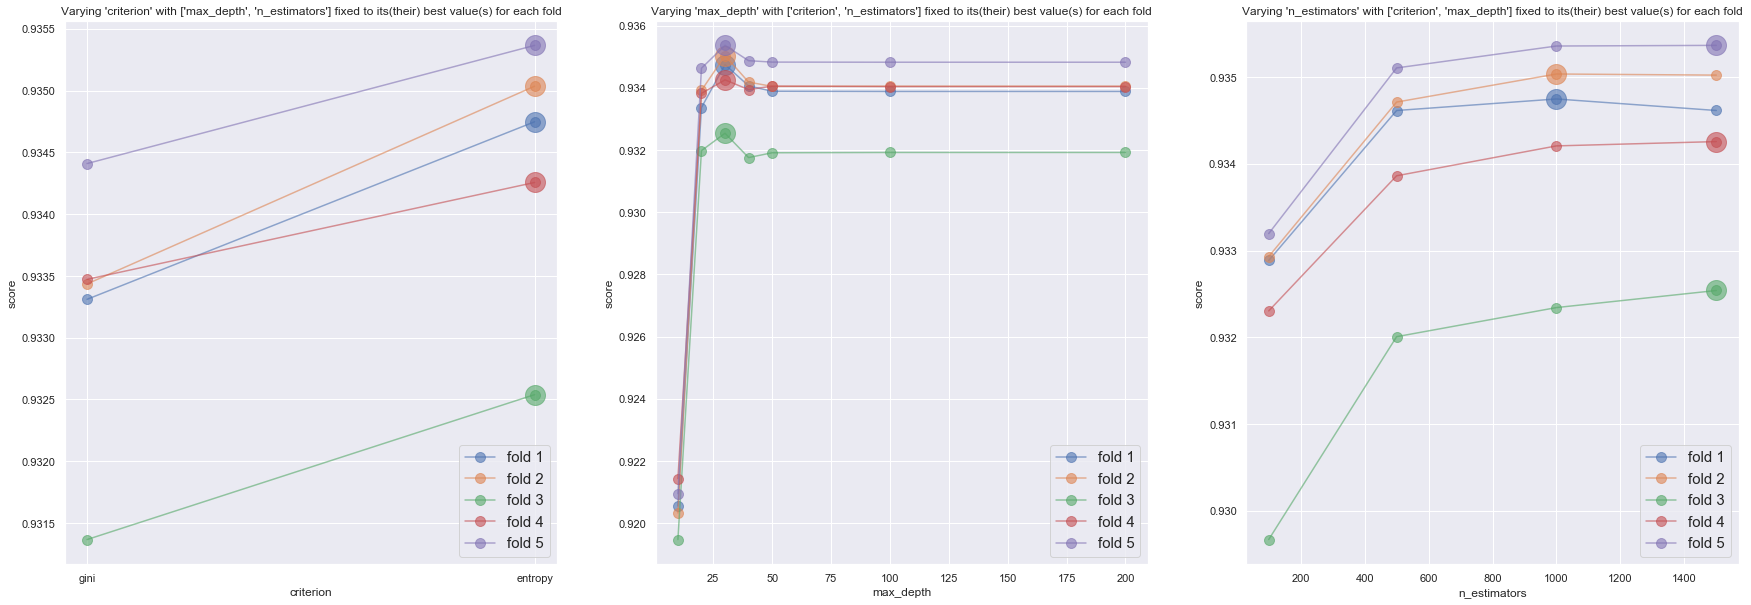

In [143]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [31]:
summary.loc['RandomForest'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

In [80]:
from sklearn.ensemble import RandomForestClassifier

model_best_RandomForestClassifier = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy')
model_best_RandomForestClassifier.fit(X, y);

This is *gini importance* (and not the mean decrease accuracy), see https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined>

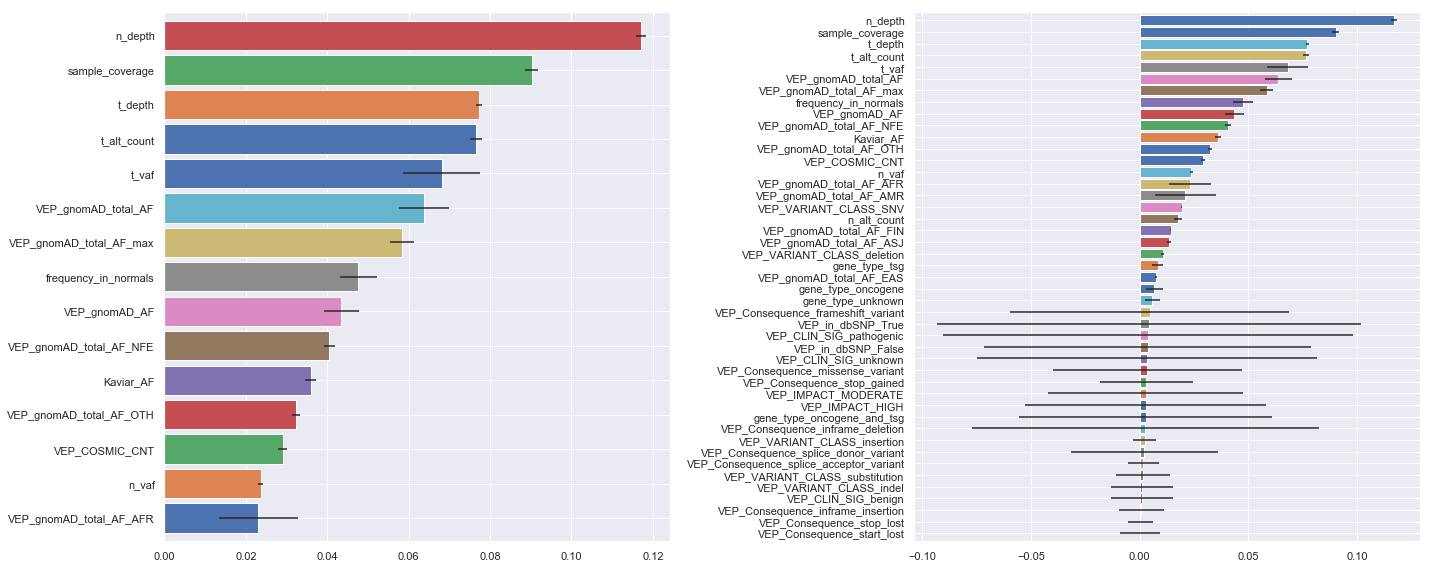

In [81]:
feature_importance = pd.DataFrame({'value': model_best_RandomForestClassifier.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

feature_importance['inter_tree_variability'] = np.std([tree.feature_importances_ for tree in model_best_RandomForestClassifier.estimators_], axis=0)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85, xerr=feature_importance.tail(15).inter_tree_variability)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85, xerr=feature_importance.inter_tree_variability)
plt.tight_layout()

## Gradient Boosting

### Create job

In [82]:
job = Selene_Job('GradientBoosting', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < GradientBoosting >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` when you create the job<br>

In [83]:
job = Selene_Job('GradientBoosting', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < GradientBoosting >: </span>✅ job found and reloaded

In [84]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_GradientBoosting


<span style="color:green">Job < GradientBoosting >: </span>✅ data loaded

In [85]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'loss': ['deviance', 'exponential'], 'learning_rate': [0.05, 0.08, 0.09, 0.1, 0.11, 0.12, 0.2], 'n_estimators': [100, 500, 1000, 1500, 2000], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 20]}
]
model = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_GradientBoosting/script.ipy


In [86]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ../ssh_remote_jobs/job_GradientBoosting to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1404     0.7KB/s   00:02    
metrics.pkl                                   100%  463KB   5.7MB/s   00:00    
script.ipy                                    100% 1006    40.9KB/s   00:00    
X.pkl                                         100% 5053KB  11.2MB/s   00:00    
y.pkl                                         100%   27KB   1.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_GradientBoosting
Job <28479832> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < GradientBoosting >: </span>✅ submitted<br>

In [87]:
job = Selene_Job('GradientBoosting', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < GradientBoosting >: </span>✅ job found and reloaded

<span style="color:red">Job < GradientBoosting >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

In [4]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy: [test_accuracy | train_accuracy]
  → ROC AUC : [test_roc_auc  | train_roc_auc] 
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [185158.37s | 0.56s]
  → accuracy: [0.919 | 1.000]
  → ROC AUC : [0.951 | 1.000]
  → best hyperparameters: {'learning_rate': 0.11, 'loss': 'exponential', 'max_depth': 10, 'n_estimators': 1000}
Fold 2: [183836.36s | 1.45s]
  → accuracy: [0.914 | 1.000]
  → ROC AUC : [0.947 | 1.000]
  → best hyperparameters: {'learning_rate': 0.08, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
Fold 3: [185037.77s | 0.57s]
  → accuracy: [0.923 | 1.000]
  → ROC AUC : [0.949 | 1.000]
  → best hyperparameters: {'learning_rate': 0.09, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
Fold 4: [174160.96s | 1.53s]
  → accuracy: [0.911 | 1.000]
  → ROC AUC : [0.948 | 1.000]
  → best hyperparameters: {'learning_rate': 0.09, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
Fold 

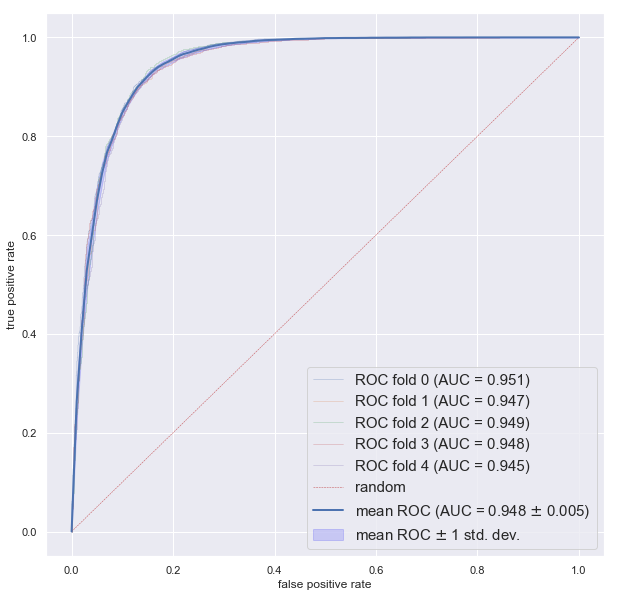

In [5]:
plot_roc_and_precision_recall(job.metrics)

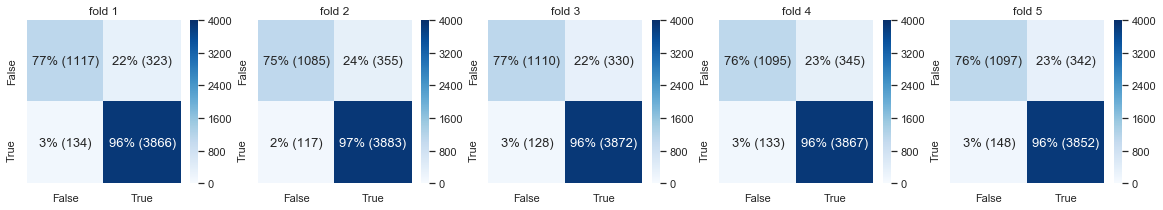

In [34]:
plot_confusion_matrix(job.metrics)

4 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → learning_rate: [0.05 0.08 0.09 0.1 0.11 0.12 0.2]
  → loss         : ['deviance' 'exponential']
  → max_depth    : [10 20 30 40 50 100 200]
  → n_estimators : [100 500 1000 1500 2000]
Best hyperparameters for each fold:
fold 0: {'learning_rate': 0.11, 'loss': 'exponential', 'max_depth': 10, 'n_estimators': 1000}
fold 1: {'learning_rate': 0.08, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
fold 2: {'learning_rate': 0.09, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
fold 3: {'learning_rate': 0.09, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}
fold 4: {'learning_rate': 0.11, 'loss': 'deviance', 'max_depth': 10, 'n_estimators': 1000}


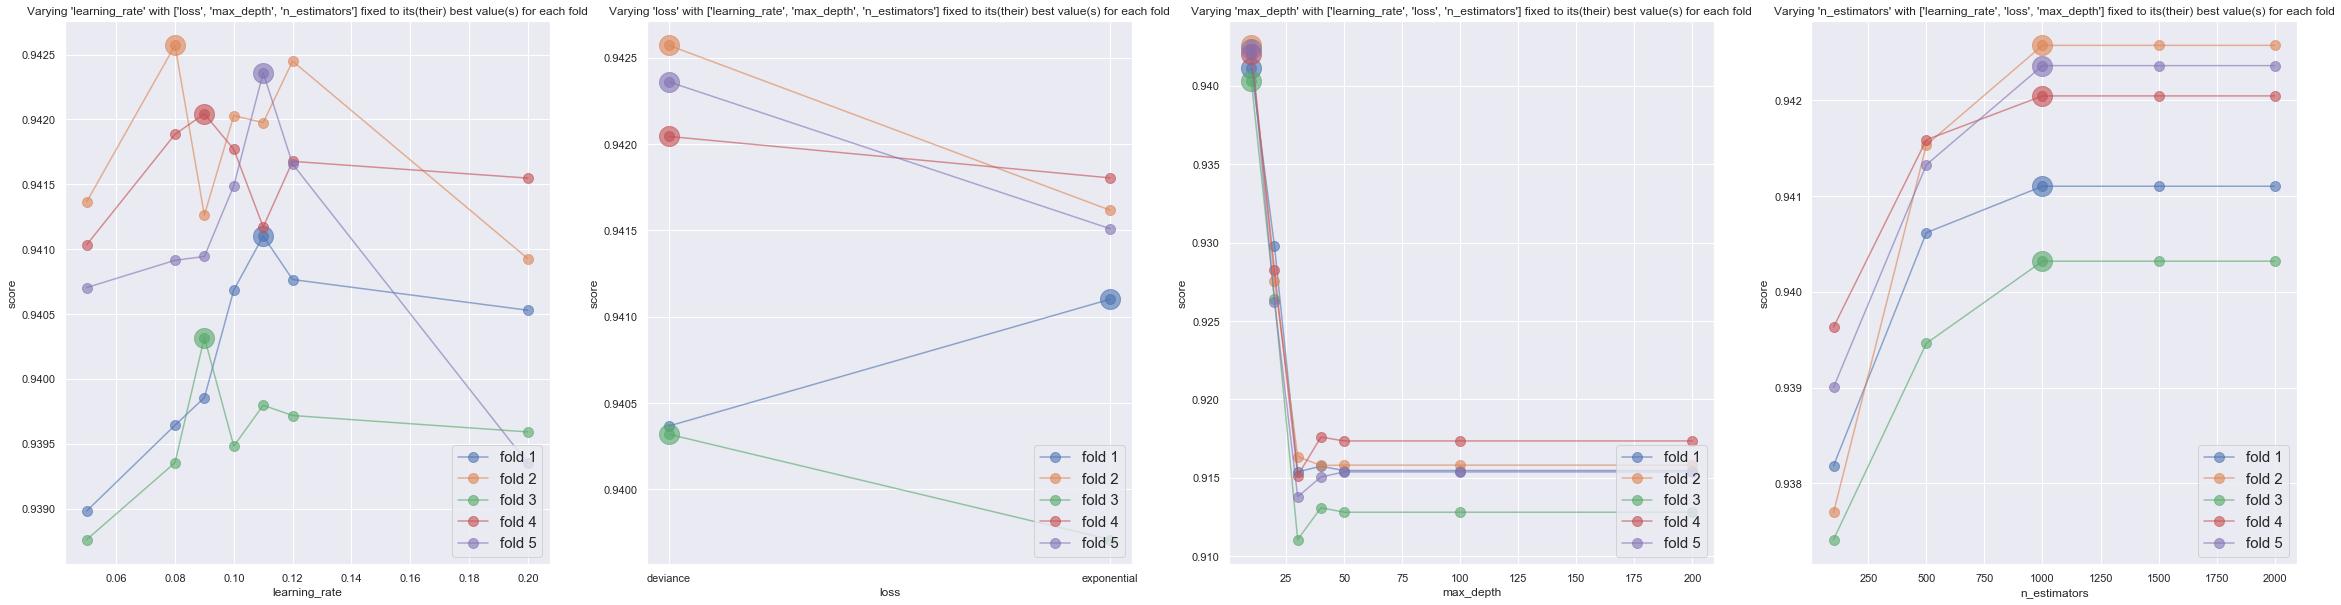

In [6]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [ ]:
summary.loc['GradientBoosting'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

model_best_GradientBoostingClassifier = GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=1000, max_depth=10, loss='deviance')
model_best_GradientBoostingClassifier.fit(X, y);

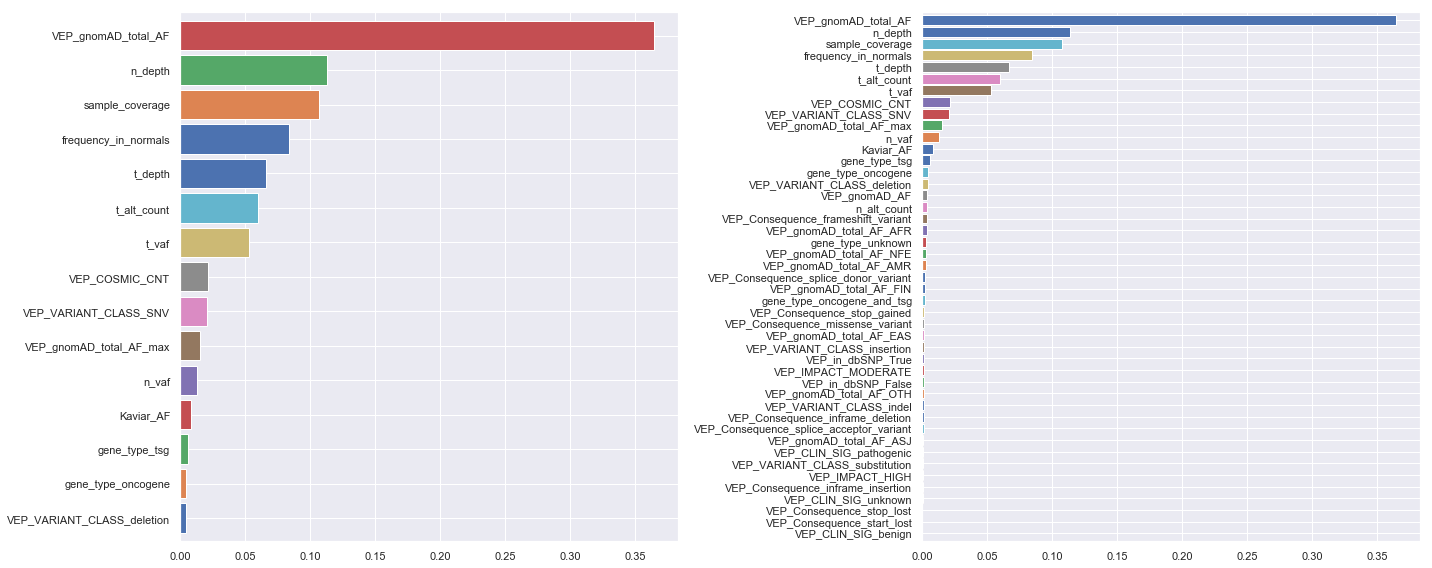

In [89]:
feature_importance = pd.DataFrame({'value': model_best_GradientBoostingClassifier.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85)
plt.tight_layout()

## Summary

In [34]:
summary = pd.read_pickle('summary.pkl')

In [97]:
summary.style.highlight_max(axis=0, color='yellow').set_precision(3)

,test_accuracy,test_roc_auc,test_f1,test_average_precision
method_name,,,,
Uniform,0.499,0.5,0.343,0.265
MostFrequent,0.735,0.5,0,0.265
GausssianNaiveBayes,0.811,0.834,0.555,0.688
RidgeRegression,0.866,0.885,0.703,0.809
LassoRegression,0.88,0.898,0.729,0.844
kNN,0.878,0.909,0.723,0.848
SVM,0.88,0.91,0.725,0.858
RandomForest,0.904,0.938,0.798,0.897


In [33]:
summary.to_pickle('summary.pkl')